In [1]:
from  netCDF4 import Dataset
import  numpy as np
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pycurrents.codas import DB
import glob
import os

In [2]:
# 1. Include an argument to choose which features to extract from database and nc files. 
# 2. 

In [2]:
# retrns the absolute path of all subdirectories in a give directory.
# this is similar to useing the nc finder function but for directories. 
def list_subdirectories(directory):
    # List to store absolute paths of subdirectories
    subdirectories = []
    
    # Walk through the directory and collect all subdirectories
    for root, dirs, _ in os.walk(directory):
        for subdir in dirs:
            # Append the absolute path of each subdirectory
            subdirectories.append(os.path.abspath(os.path.join(root, subdir)))
    
    return subdirectories

def find_dbname(directory):
    # Search for any file ending in .list in the specified directory
    list_files = glob.glob(os.path.join(directory, '*.lst'))
    
    # If no .list files are found, return None
    if not list_files:
        return None
    
    # Get the first match (assuming there might be only one or you want the first one)
    file_path = list_files[0]
    
    # Extract the filename without path and split to get the word before '.list'
    file_name = os.path.basename(file_path)
    word_before_list = file_name.rsplit('.lst', 1)[0]
    
    return word_before_list

### Load in the training data from data base. 
def db_load(dir = "/home/jamie/cruise_processing/falkortoo/FKt240817/wh300/adcpdb"):
    tag = find_dbname(dir)
    dbname = dir + "/" + tag
    db = DB(dbname)
    depth = db.get_variable('DEPTH')
    amp = db.get_variable('AMP_SOUND_SCAT') # ie signal return
    # sw = db.get_variable('SPECTRAL_WIDTH') # ie correlation
    pg = db.get_variable('PERCENT_GOOD') # ie correlation
    mask = db.get_variable('PROFILE_FLAGS')
    err = db.get_variable('ERROR_VEL')
    # error velocity sounds nice too

    features = np.stack([amp.flatten(), depth.flatten(), pg.flatten()], axis=1) # depth.flatten() err.flatten()
    predictor =  mask.flatten()
    
    return(features, predictor)

### Load in the training data from nc files. 
def nc_load(dir = "/home/jamie/cruise_processing/falkortoo/FKt240817/wh300/wh300.nc"):
    ### Load in the test data u and v for plotting. 
    file_id = Dataset(dir)
    pg = file_id.variables["pg"][:]
    amp = file_id.variables["amp"][:]
    mask = file_id.variables["pflag"][:]
    depth = file_id.variables["depth"][:]
    file_id.close()

    features = np.stack([amp.flatten(), depth.flatten(), pg.flatten()], axis=1) # depth.flatten()
    predictor =  mask.flatten()
    # error velocity sounds nice too
    return(features, predictor)

# funtion for listing all nc files in a directory with there absolute path. 
def list_nc_files(directory):
    nc_files = glob.glob(os.path.join(directory, '**', '*.nc'), recursive=True)
    # Convert to absolute paths
    nc_files = [os.path.abspath(path) for path in nc_files]
    return nc_files

def bulkload_db(dir = "/home/jamie/projects/flag_model/data/dbdirs"):
    # load train data
    # loop through the list using nc_loader and put output into an empty list then compress the list. 
    dbfiles = list_subdirectories(dir)
    X = list()
    Y = list()
    for i in range(0, len(dbfiles)):
        file = dbfiles[i]
        param, predic = db_load(file)
        X.append(param)
        Y.append(predic)
    features = np.vstack(X)
    predictor = np.hstack(Y)
    return(features, predictor)

def bulkload_nc(dir = "/home/jamie/projects/flag_model/data/ncfiles"):
    # load train data
    # loop through the list using nc_loader and put output into an empty list then compress the list. 
    dbfiles = list_nc_files(dir)
    X = list()
    Y = list()
    for i in range(0, len(dbfiles)):
        file = dbfiles[i]
        param, predic = nc_load(file)
        X.append(param)
        Y.append(predic)
    features = np.vstack(X)
    predictor = np.hstack(Y)
    predictor = predictor.flatten()
    return(features, predictor)

def what_flags(x, y, arg = [0, 1, 2, 3, 4, 5, 6, 7]):
    # Only train on the good stuf. 
    idx = np.isin(y, arg)
    usr_mask = idx.flatten()
    x = x[idx, :]
    # make all masks 0 or 1. Needed if other flags are used. 
    y = y[usr_mask]
    y[y != 0] = 1
    return(x, y)

In [4]:
features, predictor = bulkload_db(dir = "/home/jamie/projects/flag_model/data/dbdirs")
features, predictor = what_flags(features, predictor, arg = [0, 1])

# run the model
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(train_cruise)
X_train, X_test, y_train, y_test = train_test_split(features, predictor, test_size=0.7, random_state=42, stratify=predictor)
model = LogisticRegression(max_iter=7000)  
model.fit(X_train, y_train)

Perceptron(max_iter=7000, tol=1e-05)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

features, predictor = bulkload_db(dir = "/home/jamie/projects/flag_model/data/dbdirs")
features, predictor = what_flags(features, predictor, arg = [0, 1])

# run the model
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(train_cruise)
X_train, X_test, y_train, y_test = train_test_split(features, predictor, test_size=0.7, random_state=42, stratify=predictor)
# model = LogisticRegression(max_iter=7000)  

# Build the model
model = Sequential([
    Dense(160, activation='relu', input_dim=X_train.shape[1]),  # Hidden layer 1
    Dense(80, activation='relu'),                              # Hidden layer 2
    Dense(1, activation='sigmoid')                            # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split=0.2, verbose=1)

### Load in the test data u for plotting. 
file_id = Dataset('/home/jamie/cruise_processing/falkortoo/FKt240224/wh300_patch/contour/wh300.nc')
u = file_id.variables["v"][:]
file_id.close()
s = u.shape

# laod test data for the model.
features_test, predictor_test = db_load("/home/jamie/cruise_processing/falkortoo/FKt240224/wh300_patch/adcpdb")
new_y_pred = model.predict(features_test) 
# put humpoty dumpty back together again
pred_flags = new_y_pred.reshape(s[0], s[1]) 
predictor_test = predictor_test.reshape(s[0], s[1]) 
# predictor_test[predictor_test != 0] = 1

# Everything that isnt unflagged or manually flagged is now identified. 
auto_flagged = predictor_test.copy()
bin_flag = predictor_test.copy()

# subset only the algorithm falgs
arg = [0, 1]# , 2, 3, 4, 5, 6, 7] #, 2, 6]
idx = np.isin(predictor_test, arg)
auto_flagged[~idx] = 1
auto_flagged[idx] = 0

# subset only the manualy edited falgs
arg = [1]# , 2, 3, 4, 5, 6, 7] #, 2, 6]
idx = np.isin(predictor_test, arg)
bin_flag[~idx] = 0

# subset only the all the flags. 
all_flag = predictor_test.copy()
all_flag[all_flag != 0] = 1

idx = range(3400, 3800)

# Define the feature array and predicted mask array
feature = u # n by m array
predicted_mask = pred_flags  # n by m array

fig, ax = plt.subplots(2, 1, figsize=(14, 8))
contour1 = ax[0].contourf(feature.T[:, idx], cmap='RdBu', levels=50)
# contour1.set_clim(-0.4, 0.4)
# Overlay the predicted mask as a contour on top with transparency
ax[0].contourf(predicted_mask.T[:, idx], levels=[0.5, 1], colors='grey', alpha=1)
ax[0].contourf(auto_flagged.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.8)
ax[0].set_title('Ocean velocity with with predicted mask')
ax[0].set_ylim(50, 0)

contour2 = ax[1].contourf(feature.T[:, idx], cmap='RdBu',levels=50)
# contour2.set_clim(-0.4, 0.4)
# Overlay the predicted mask as a contour on top with transparency
ax[1].contourf(bin_flag.T[:, idx], levels=[0.5, 1], colors='grey', alpha=1)
ax[1].contourf(auto_flagged.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.9)
ax[1].set_title('Ocean velocity with with known mask')
ax[1].set_ylim(50, 0)
# fig.colorbar(contour2, ax=ax, orientation='vertical', label="ocean velocity")
plt.tight_layout()
plt.show()

2024-11-15 12:45:51.804453: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 12:45:51.805831: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-15 12:45:51.808872: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-15 12:45:51.816205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731710751.832024  563633 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731710751.83

Epoch 1/10


/home/jamie/miniconda3/envs/uhdas/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-15 12:45:54.041611: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


42301/42301 ━━━━━━━━━━━━━━━━━━━━ 34s 787us/step - accuracy: 0.9211 - loss: 0.2186 - val_accuracy: 0.9251 - val_loss: 0.1992
Epoch 2/10
42301/42301 ━━━━━━━━━━━━━━━━━━━━ 33s 768us/step - accuracy: 0.9266 - loss: 0.1956 - val_accuracy: 0.9245 - val_loss: 0.1971
Epoch 3/10
42301/42301 ━━━━━━━━━━━━━━━━━━━━ 31s 726us/step - accuracy: 0.9263 - loss: 0.1914 - val_accuracy: 0.9250 - val_loss: 0.1894
Epoch 4/10
42301/42301 ━━━━━━━━━━━━━━━━━━━━ 30s 701us/step - accuracy: 0.9269 - loss: 0.1882 - val_accuracy: 0.9263 - val_loss: 0.1837
Epoch 5/10
42301/42301 ━━━━━━━━━━━━━━━━━━━━ 36s 847us/step - accuracy: 0.9271 - loss: 0.1851 - val_accuracy: 0.9257 - val_loss: 0.1855
Epoch 6/10
42301/42301 ━━━━━━━━━━━━━━━━━━━━ 36s 841us/step - accuracy: 0.9268 - loss: 0.1852 - val_accuracy: 0.9267 - val_loss: 0.1831
Epoch 7/10
42301/42301 ━━━━━━━━━━━━━━━━━━━━ 36s 839us/step - accuracy: 0.9283 - loss: 0.1831 - val_accuracy: 0.9267 - val_loss: 0.1851
Epoch 8/10
42301/42301 ━━━━━━━━━━━━━━━━━━━━ 36s 843us/step - accur

In [4]:
### Load in the test data u for plotting. 
file_id = Dataset('/home/jamie/cruise_processing/falkortoo/FKt240224/wh300_patch/contour/wh300.nc')
u = file_id.variables["v"][:]
file_id.close()
s = u.shape

# laod test data for the model.
features_test, predictor_test = db_load("/home/jamie/cruise_processing/falkortoo/FKt240224/wh300_patch/adcpdb")
new_y_pred = model.predict(features_test) 
# put humpoty dumpty back together again
pred_flags = new_y_pred.reshape(s[0], s[1]) 
predictor_test = predictor_test.reshape(s[0], s[1]) 
# predictor_test[predictor_test != 0] = 1

48950/48950 ━━━━━━━━━━━━━━━━━━━━ 23s 463us/step


In [5]:
# Everything that isnt unflagged or manually flagged is now identified. 
auto_flagged = predictor_test.copy()
bin_flag = predictor_test.copy()

# subset only the algorithm falgs
arg = [0, 1]# , 2, 3, 4, 5, 6, 7] #, 2, 6]
idx = np.isin(predictor_test, arg)
auto_flagged[~idx] = 1
auto_flagged[idx] = 0

# subset only the manualy edited falgs
arg = [1]# , 2, 3, 4, 5, 6, 7] #, 2, 6]
idx = np.isin(predictor_test, arg)
bin_flag[~idx] = 0

# subset only the all the flags. 
all_flag = predictor_test.copy()
all_flag[all_flag != 0] = 1

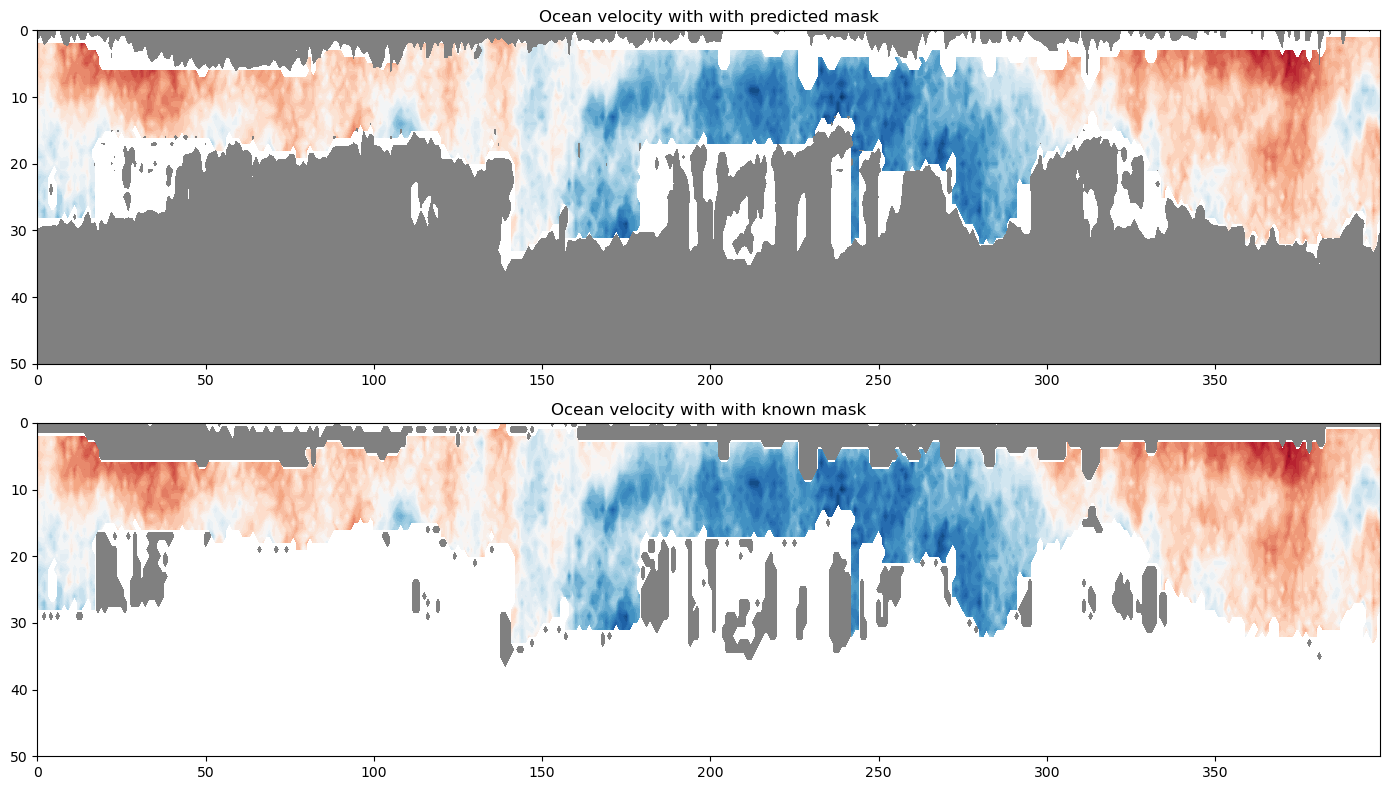

In [12]:
idx = range(3400, 3800)

# Define the feature array and predicted mask array
feature = u # n by m array
predicted_mask = pred_flags  # n by m array

fig, ax = plt.subplots(2, 1, figsize=(14, 8))
contour1 = ax[0].contourf(feature.T[:, idx], cmap='RdBu', levels=50)
# contour1.set_clim(-0.4, 0.4)
# Overlay the predicted mask as a contour on top with transparency
ax[0].contourf(predicted_mask.T[:, idx], levels=[0.5, 1], colors='grey', alpha=1)
# ax[0].contourf(auto_flagged.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.8)
ax[0].set_title('Ocean velocity with with predicted mask')
ax[0].set_ylim(50, 0)

contour2 = ax[1].contourf(feature.T[:, idx], cmap='RdBu',levels=50)
# contour2.set_clim(-0.4, 0.4)
# Overlay the predicted mask as a contour on top with transparency
ax[1].contourf(bin_flag.T[:, idx], levels=[0.5, 1], colors='grey', alpha=1)
# ax[1].contourf(auto_flagged.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.9)
ax[1].set_title('Ocean velocity with with known mask')
ax[1].set_ylim(50, 0)
# fig.colorbar(contour2, ax=ax, orientation='vertical', label="ocean velocity")
plt.tight_layout()
plt.show()

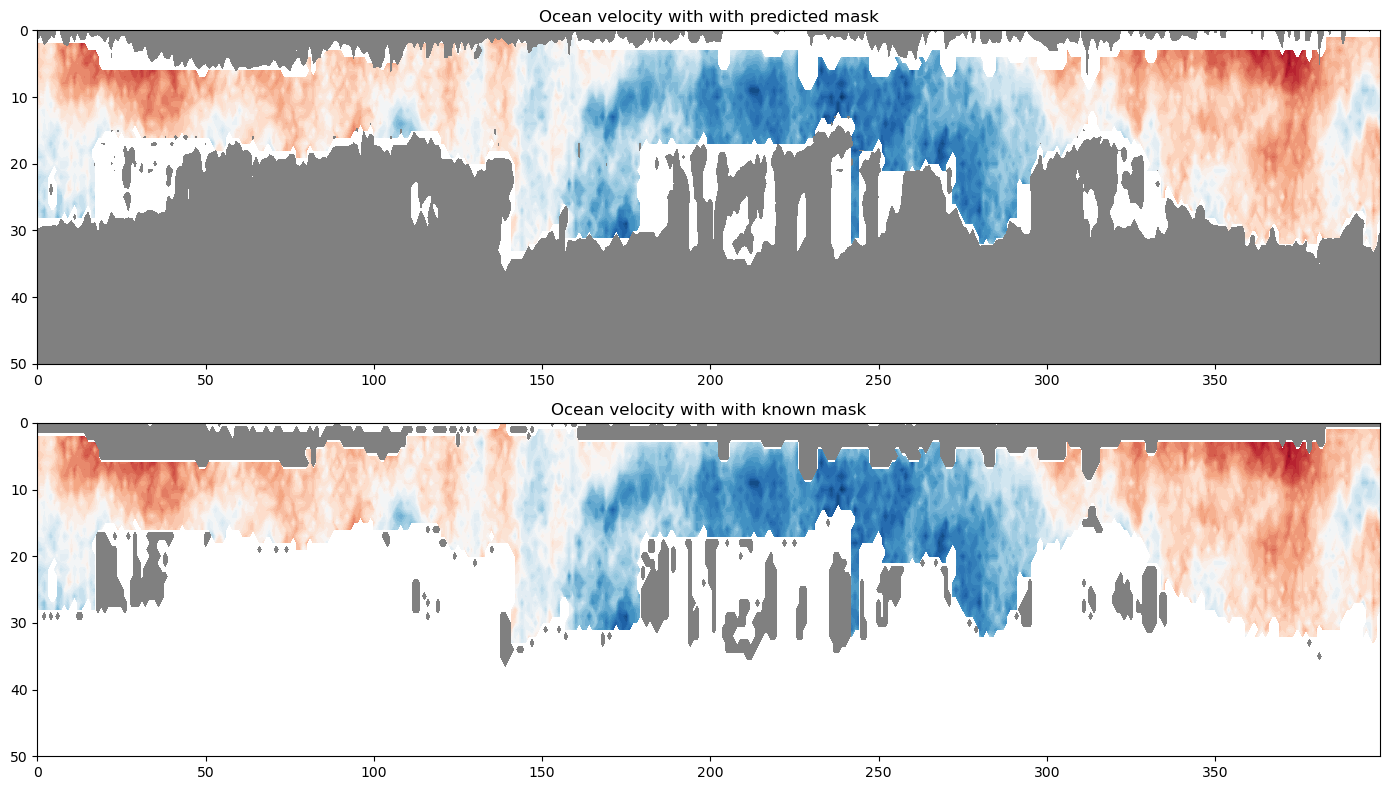

In [11]:
idx = range(3400, 3800)

# Define the feature array and predicted mask array
feature = u # n by m array
predicted_mask = pred_flags  # n by m array

fig, ax = plt.subplots(2, 1, figsize=(14, 8))
contour1 = ax[0].contourf(feature.T[:, idx], cmap='RdBu', levels=50)
# contour1.set_clim(-0.4, 0.4)
# Overlay the predicted mask as a contour on top with transparency
ax[0].contourf(predicted_mask.T[:, idx], levels=[0.5, 1], colors='grey', alpha=1)
# ax[0].contourf(auto_flagged.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.8)
ax[0].set_title('Ocean velocity with with predicted mask')
ax[0].set_ylim(50, 0)

contour2 = ax[1].contourf(feature.T[:, idx], cmap='RdBu',levels=50)
# contour2.set_clim(-0.4, 0.4)
# Overlay the predicted mask as a contour on top with transparency
ax[1].contourf(bin_flag.T[:, idx], levels=[0.5, 1], colors='grey', alpha=1)
# ax[1].contourf(auto_flagged.T[:, idx], levels=[0.5, 1], colors='black', alpha=0.9)
ax[1].set_title('Ocean velocity with with known mask')
ax[1].set_ylim(50, 0)
# fig.colorbar(contour2, ax=ax, orientation='vertical', label="ocean velocity")
plt.tight_layout()
plt.show()